# Overview
The famous ARIMA model is basically a Linear Regression model on a time series' own lags. So what if we replace the simple Linear Regression with a state-of-the-art tabular learning algorithm? This (known under the term *reduction*) is one example of useful features in [Sktime]. In this topic, we are going to use this library to implement a lot of forecasting tasks such as reduction, forecasting, backtesting and evaluation, in an unified way.

[Sktime]: https://www.sktime.org/en/stable/index.html

# 1. Forecasting interface

## 1.1. Basic workflow

In [9]:
import datetime as dt
from sspipe import p, px
import warnings; warnings.filterwarnings('ignore')
import logging; logging.basicConfig(level=logging.ERROR)

import numpy as np
import pandas as pd
import janitor
from sktime.forecasting.base import ForecastingHorizon as FH
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

### Input format
The appropriate format of input data for Sktime is a Pandas Series or DataFrame with
<code style='font-size:13px'><a href=https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html>DatetimeIndex</a></code> and
<code style='font-size:13px'><a href=https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.PeriodIndex.html>PeriodIndex</a></code>.
There are different date and time [frequencies] available, but in this section we will demonstrate with a practical use case: business day frequency.
For non-time-series sequential data, Sktime also accepts integer index.

[frequencies]: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [2]:
dfQty = (
    pd.read_csv('data/weekly_quantity.csv')
    .eval("date = date.astype('datetime64')", engine='python')
    .set_index('date')
    .rename_axis(index=None)
    .asfreq('B')
    .fillna(1e-3)
    .to_period('B')
)
dfQty.tail()

,quantity
2015-06-26,58.07
2015-06-29,59.83
2015-06-30,47.84
2015-07-01,52.20
2015-07-02,44.57


### Forecasters
A pain point occurs in forecasting tasks is that different Python packages such as Statsmodels, PmdArima and Prophet use different fit and predict syntaxes. Sktime serves the role of an unified framework that wraps popular forecasting models so that Data Scientists can try different models with ease. Sktime supports all popular models, some with an automated version:
<code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.arima.AutoARIMA.html>AutoARIMA</a></code>
<code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.ets.AutoETS.html>AutoETS</a></code>
<code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.tbats.TBATS.html>TBATS</a></code>
<code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.fbprophet.Prophet.html>Prophet</a></code>.

In [6]:
model = AutoARIMA(sp=5)
model.fit(dfQty)

AutoARIMA(sp=5)

In [7]:
model.cutoff

Period('2015-07-02', 'B')

<b style='color:navy'><i class="fa fa-info-circle"></i>&nbsp; Note</b><br>
- Once the model is fitted, the last observed value is call the *offset*, indexed 0. It can be thought as the *now* state of the time series.
- We can either request future forecasts (*out-of-sample forecasting*) with the indices start from 1, or request historical fitted values (*in-sample prediction*) with negative indices. However, some models will return NA for in-sample prediction.

In [23]:
fh = np.arange(-1, 3)
model.predict(fh)

,quantity
2015-07-01,NaN
2015-07-02,NaN
2015-07-03,45.301294
2015-07-06,53.462003


### Forecasting horizon
The most simple way to request forecasts is using integer indices as above, but sometimes, we need a more pwerful tool. Sktime has a
<code style='font-size:13px'><a href=1>ForecastingHorizon</a></code>
class allowing us to specifiy either relative or absolute horizon.

[1]: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.base.ForecastingHorizon.html

In [24]:
fhRel = np.arange(-1, 3) | p(FH)
display(fhRel)
model.predict(fhRel)

ForecastingHorizon([-1, 0, 1, 2], dtype='int64', is_relative=True)

,quantity
2015-07-01,NaN
2015-07-02,NaN
2015-07-03,45.301294
2015-07-06,53.462003


In [25]:
fhAbs = pd.period_range('2015-07-01', '2015-07-06', freq='B') | p(FH, is_relative=False)
model.predict(fhAbs)

,quantity
2015-07-01,NaN
2015-07-02,NaN
2015-07-03,45.301294
2015-07-06,53.462003


In [26]:
cutoff = pd.Period('2015-07-02', freq='B')
fhRel.to_absolute(cutoff) | p(display)

ForecastingHorizon(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06'], dtype='period[B]', is_relative=False)

### Update and predict
We have already known forecasting for far future points is not very accurate, as forecasting errors keep stacking up. For example, if we have daily data, then the forecast for this day next month $\hat{y}_{t+30|t}$ is not likely to have high quality, no matter how strong the algorithm we are using is. In this case, the approach to solve the problem is more important. A simple but good solution is re-training the model more frequently, like weekly or even daily. This strategy makes the cutoff closer to the query point: $\hat{y}_{t+7|t}$ (weekly) and $\hat{y}_{t+1|t}$ (daily).

The downside of frequent re-training is computation cost. Sktime offers a solution with lower training time but does not hurt the quality very much, that is updating. When calling the <code style='font-size:13px'>update()</code> method, the fitted model ingests new data and updates the cutoff to the last observed point. Let's see the behaviour of this method in action.

In [27]:
model = AutoARIMA()
model.fit(dfQty[:-5])
model.cutoff

Period('2015-06-25', 'B')

In [28]:
# after updating new 5 observations, the cutoff moves
model.update(dfQty[-5:])
model.cutoff

Period('2015-07-02', 'B')

In [29]:
fh = FH([1,2,3])
model.predict(fh)

,quantity
2015-07-03,50.533391
2015-07-06,53.435979
2015-07-07,52.105592


### Probabilistic prediction
Some Sktime forecasters have the ability to perform probabilistic prediction. Two common options are confidence interval (the user specifies a coverage) and distribution quantiles (the user specifies quantiles). I highly recommend using
<code style='font-size:13px'>predict_quantiles()</code>
because it can cover both
<code style='font-size:13px'>predict()</code> and <code style='font-size:13px'>predict_interval()</code>.
For forecasters who don't support probabilistic prediction, Sktime supports some [wrappers] to enable this feature without affecting forecasting results.

[wrappers]: https://www.sktime.org/en/stable/api_reference/forecasting.html#prediction-intervals

In [30]:
model.predict_interval(fh, coverage=0.9)

Coverage           
                  0.9           
                lower      upper
2015-07-03  34.881345  66.185437
2015-07-06  37.330719  69.541240
2015-07-07  35.862179  68.349005

In [31]:
model.predict_quantiles(fh, alpha=[0.05, 0.1, 0.5, 0.9, 0.95])

Quantiles                                            
                 0.05       0.10       0.50       0.90       0.95
2015-07-03  34.881345  38.338444  50.533391  62.728339  66.185437
2015-07-06  37.330719  40.887919  53.435979  65.984039  69.541240
2015-07-07  35.862179  39.449893  52.105592  64.761290  68.349005

### Exogeneous variables
Traditional statistical models, especially SARIMAX, have considered independent variables that potentially have a strong relationship with our time series. In terms of forecasting, the time series we want to make forecasts is called the *endogeneous* variable $\mathbf{y}$ and other independent time series are called *exogeneous* variables $\mathbf{x}_1,\mathbf{x}_2,\ldots$. When exogeneous variables are included in the forecaster, then the model becomes: $f:\mathbf{y}_{t-1},\mathbf{y}_{t-2},\ldots\mathbf{x}_1,\mathbf{x}_2,\ldots\mapsto\mathbf{y}$.

However, in the inference phase, it requres values of the exogeneous variables at future time steps that we are requesting forecast. This makes only special variables with appointed time (such as holidays and special events) a viable option. There is a workaround solution to involve economical data (which is much more useful), which is using their lags. For example, to forecast a variable $\mathbf{y}$ for the next 7 days, we can use $\mathbf{x}_{t-7}$ for training and leave $7$ latest values of $\mathbf{x}$ for inference.

In [32]:
dfTemp = pd.read_csv('data/air_quality.csv')
dfTemp = (
    dfTemp
    .to_datetime('time')
    .select_columns(['time', 'temp', '*humidity'])
    .set_index('time')
    .asfreq('h')
    .rename_axis(index=None)
    .loc['2005-01-15': '2005-03-15']
)
dfTemp.tail()

,temp,rel_humidity,abs_humidity
2005-03-15 19:00:00,18.0,36.0,0.7345
2005-03-15 20:00:00,16.4,41.9,0.7759
2005-03-15 21:00:00,14.9,47.6,0.8003
2005-03-15 22:00:00,13.8,49.6,0.7793
2005-03-15 23:00:00,13.2,51.6,0.7765


In [33]:
nForecast = 24

x = dfTemp.select_columns('*humidity')
x.index = x.index.shift(nForecast) # 16/01 to 16/03
xTrain = x[:-nForecast] # 16/01 to 15/03
xQuery = x[-nForecast:] # 16/03

y = dfTemp.select_columns('temp')
yTrain = y[nForecast:] # 16/01 to 15/03

In [34]:
model = AutoARIMA()
model.fit(yTrain, xTrain)

AutoARIMA()

In [35]:
fh = np.arange(1, nForecast+1)
yPred = model.predict(fh, xQuery)
yPred.iloc[[0,1,2,-3,-2,-1]]

,temp
2005-03-16 00:00:00,12.424923
2005-03-16 01:00:00,12.301092
2005-03-16 02:00:00,11.337493
2005-03-16 21:00:00,6.075261
2005-03-16 22:00:00,5.596284
2005-03-16 23:00:00,5.127052


## 1.2. Forecasting reduction
In order to reduce a forecasting problem to a regression problem, we need to re-arrange the time series into a table so that itself ($\mathbf{y}_t$) becomes the label and its lags ($\mathbf{y}_{t-1},\mathbf{y}_{t-2},\dots$) become the features. There are three approaches to make prediction to multiple future time steps: recursive reduction, direct reduction and a hybrid between them, implemented in a single function,
<code style='font-size:13px'><a href='https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html'>make_reduction()</a></code>.

In [63]:
import numpy as np
import pandas as pd
import janitor
import sktime
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.conformal import ConformalIntervals
from sktime.forecasting.naive import NaiveVariance
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [37]:
dfTemp = pd.read_csv('data/air_quality.csv')
dfTemp = (
    dfTemp
    .to_datetime('time')
    .select_columns(['time', 'temp'])
    .also(lambda df: display(df.tail()))
    .set_index('time')
    .asfreq('h')
    # .to_period('h')
)

,time,temp
9352,2005-04-04 10:00:00,21.9
9353,2005-04-04 11:00:00,24.3
9354,2005-04-04 12:00:00,26.9
9355,2005-04-04 13:00:00,28.3
9356,2005-04-04 14:00:00,28.5


In [38]:
dfQty = (
    pd.read_csv('data/weekly_quantity.csv')
    .eval("date = date.astype('datetime64')", engine='python')
    .set_index('date')
    .rename_axis(index=None)
    .asfreq('D')
    .fillna(1e-3)
    .to_period('D')
)
dfQty.tail()

,quantity
2015-06-28,81.97
2015-06-29,59.83
2015-06-30,47.84
2015-07-01,52.20
2015-07-02,44.57


### Recursive strategy
This is the strategy used in traditional models such as ARIMA and ETS, it trains a model $f:\mathbf{y}_{t-1},\mathbf{y}_{t-2},\ldots\mapsto\mathbf{y}_t$. Denote the last observed value $y_T$, the model first predicts $\hat{y}_{T+1|T}$, then appends it to the original series to predict $\hat{y}_{T+2|T+1}$. This behaviour is repeated until all future time steps have been forecasted. This strategy has a significant weakness, is that it accumulates error each time it makes prediction to a new time step. Hence, requesting forecasts for a large horizon using this strategy is not a good idea, as it can saturate/converge and is no longer accurate.

<img src='image/forecast_reduction_recursive.png' style='height:300px; margin:20px auto 20px;'>

In [40]:
nLags = 5
model = LGBMRegressor() | p(make_reduction, window_length=nLags, strategy='recursive') | p(NaiveVariance)
model.fit(dfQty)
model

NaiveVariance(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(),
                                                              window_length=5))

In [45]:
fh = [1,2,3]
model.predict_quantiles(fh, alpha=[0.1, 0.5, 0.9])

Quantiles                      
                  0.1        0.5        0.9
2015-07-03  30.854224  46.700918  62.547613
2015-07-04  62.759034  79.105981  95.452927
2015-07-05  56.578788  73.969520  91.360253

In [54]:
model.forecaster_.estimator_.feature_importances_

array([83, 82, 48, 70, 73])

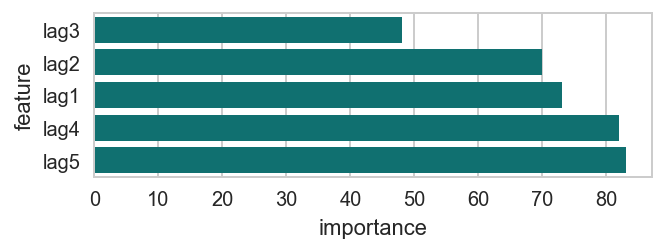

In [57]:
nTop = 10

df = pd.DataFrame({
    'feature': [f'lag{i}' for i in range(nLags, 0, -1)],
    'importance': model.forecaster_.estimator_.feature_importances_,
})
df = df.sort_values('importance')
df = df.query("importance > 0")
df = df.tail(nTop)

fig, ax = plt.subplots(figsize=(5,1.5))
sns.barplot(data=df, x='importance', y='feature', color='teal')
plt.show()

### Direct strategy
This strategy, in the other hand, trains a separate model for each time step: $f_h:\mathbf{y}_{t-h},\mathbf{y}_{t-(h+1)},\ldots\mapsto\mathbf{y}_t$. As the number of models need to be train equals to the length of the forecasting horizon, this method is more computationally expensive but more accurate than recursive reduction. Keep in mind that making forecast to a far time step prevents using recent lags ($y_{t-1},\ldots,y_{t-(h-1)}$). In other the words, if $h$ is large then $f_h$ is trained on less features and thus has less prediction power. Also note that because this method is a combination of multiple models, we must specify the forecasting horizon when fitting it to the data.

<img src='image/forecast_reduction_direct.png' style='height:300px; margin:20px auto 20px;'>

In [58]:
nLags = 10
model = make_reduction(LGBMRegressor(), window_length=nLags, strategy='direct', scitype='tabular-regressor')
model.fit(dfTemp, fh=[1,2,3])
model

DirectTabularRegressionForecaster(estimator=LGBMRegressor())

In [9]:
model.predict()

,temp
2005-04-04 15:00:00,26.332280
2005-04-04 16:00:00,29.458241
2005-04-04 17:00:00,25.562921


In [10]:
model.estimators_[0].feature_importances_

array([393, 332, 205, 242, 265, 283, 170, 166, 261, 683], dtype=int32)

### Hybrid strategy
Sktime also develops a hybrid method that combines two above strategies, call *dir-rec*. It also has a recursive behaviour, but after appending $\hat{y}_{T+h|T+(h-1)}$, it trains a new model to predict the next step $\hat{y}_{T+(h+1)|T+h}$. However, because both recursion reduction and direct reduction are not good at forecasting far horizons, *dir-rec* also suffers from this problem.

In [11]:
nLags = 10
model = make_reduction(LGBMRegressor(), window_length=nLags, strategy='dirrec', scitype='tabular-regressor')
model.fit(dfTemp, fh=[1,2,3])
model

DirRecTabularRegressionForecaster(estimator=LGBMRegressor())

### Multivariate reducer
As Sktime currently does not support forecasting reduction for multivariate time series (where multiple time series grow together), we are going to use Skforecast's [multivariate forecasting] instead. Its class
<code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/0.5.1/api/ForecasterMultiSeries.html'>ForecasterAutoregMultiSeries</a></code>
assumes multiple time series are independent but follow the same patterns (for example, the sales of different products in the same store).

Another reducer being capable of modeling relationship between different time series are being developed. Its assumption is that, each time series depends not only on its own past values, but also on past values of other time series.

[multivariate forecasting]: https://joaquinamatrodrigo.github.io/skforecast/0.5.1/user_guides/multi-time-series-forecasting.html

In [12]:
import numpy as np
import pandas as pd
import janitor

import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries

import warnings; warnings.filterwarnings('ignore')

In [13]:
dfTemp = pd.read_csv('data/air_quality.csv')
dfTemp = (
    dfTemp
    .to_datetime('time')
    .select_columns(['time', 'temp', 'rel_humidity', 'abs_humidity'])
    .set_index('time')
    .asfreq('h')
)
dfTemp.tail()

,temp,rel_humidity,abs_humidity
time,,,
2005-04-04 10:00:00,21.9,29.3,0.7568
2005-04-04 11:00:00,24.3,23.7,0.7119
2005-04-04 12:00:00,26.9,18.3,0.6406
2005-04-04 13:00:00,28.3,13.5,0.5139
2005-04-04 14:00:00,28.5,13.1,0.5028


In [14]:
model = ForecasterAutoregMultiSeries(
    LGBMRegressor(max_depth=3), lags=5,
)
model.fit(dfTemp)
model.predict_interval(steps=7, level='temp')

,pred,lower_bound,upper_bound
2005-04-04 15:00:00,29.337819,27.115810,32.904596
2005-04-04 16:00:00,29.320193,21.437085,35.128758
2005-04-04 17:00:00,28.888693,20.691483,36.479229
2005-04-04 18:00:00,28.581748,18.914208,37.279164
2005-04-04 19:00:00,28.345217,16.265546,38.106760
2005-04-04 20:00:00,28.345217,4.779529,38.194939
2005-04-04 21:00:00,28.581748,4.449700,38.651095


In [15]:
model.get_feature_importance()

,feature,importance
0,lag_1,273
1,lag_2,111
2,lag_3,63
3,lag_4,66
4,lag_5,126
5,abs_humidity,0
6,rel_humidity,13
7,temp,0


# 2. Forecasting validation

## 2.1. Scoring metrics
Sktime supports a lot of [performance metrics] for time series forecasting. To better understand all of them, let's first break down each metric into three parts: *error* function, *squared* flag and *aggregation* strategy. We illustrate the break down process using a familiar metric, mean squared error.
- The type of error refers to how error is calculated for each observation. This is the centre of the metric and will be discussed later. In the case of MSE, the error is simply the difference between the true and forecasting values.
- Errors calculated in any way can be positive or negative, so they can eliminate each other. We can either take the *absolute* value or *squared* value to make the errors always positive. The choice of square function penalizes large errors.
- Two above functions give us the error for each observation, so we need a function to aggregate the result for the entire target variable. Most popular options are (arithmetic) *mean* and *median*, but people also use *geometric mean*.

For summary, all types of error present in this section have the term $y_t-\hat{y}_t$ in their nominator, so that they are all *lower-is-better*. Their ranges are $(0,\infty)$, and their best values are $0$.

[performance metrics]: https://www.sktime.org/en/stable/api_reference/performance_metrics.html

### Baseline forecasters
Many evaluation metrics for time series forecasting involve a [baseline model] (also known as benchmark model) in its calculation. The reason is very simple: because these baseline forecasters really make sense. Sktime implements all three strategies via the class
<code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html>NaiveForecaster</a></code>.

- *Average model*: the forecast for all future values are equal to the average of observed values:

$$\hat{y}_t=\frac{y_1+y_2+\ldots+y_T}{T}$$

- *Drift model*: we draw a line from the first to the last observed point, then extrapolate it into the future:

$$\hat{y}_t=y_1+t\left(\frac{y_T-y_1}{T-1}\right)$$

- *Naive model*: we take the last observed value of the same season (time step $t-m$, with $m$ the seasonal period) as the forecast at a time step. If data has no seasonality then $m=1$. The formulation is:

$$\hat{y}_t=y_{t-m} $$

[baseline model]: https://en.wikipedia.org/wiki/Forecasting#Categories_of_forecasting_methods

### Difference error
$$e_t=y_t-\hat{y}_t$$

Two popular metrics of this type are [MSE] and [MAE], also have been seen in evaluating regression problems. These two metrics are scale-dependent, so that they can express in the same unit as the time series. Scale-dependence is also a disadvantage, as we cannot use these metrics to decide if a model is good enough.

An approach to solve this is to take the ratio between the metric of our Machine Learning model (like $\text{MSE}$) and the metric of a naive baseline forecaster ($\text{MSE}^*$). This metric is called *Relative Loss*, computed as:

$$\text{RelativeMSE}=\frac{\text{MSE}}{\text{MSE}^*} $$

[MSE]: https://en.wikipedia.org/wiki/Mean_squared_error
[MAE]: https://en.wikipedia.org/wiki/Mean_absolute_error

### Percentage error
$$e_t=\frac{y_t-\hat{y}_t}{y_t}$$

[MAPE] is the most popular metric for this type of error. It is *scale-independent* and *high-interpretable*, so it can be considered the standard metric for forecasting tasks. However, percentage error suffers from many known issues:
- It cannot be used when $y_t=0$ and tends towards infinity when $y_t\approx0$.
- It is meaningless for data in [interval scale] (for example, temperatures), in which the ratio is not defined.
- An controversial issue that percentage error is said to have, is its asymmetry. The symmetric counterpart is given by:

$$e_t=\frac{2(y_t-\hat{y}_t)}{|y_t|+|\hat{y}_t|} $$

In this formula, the nominator is multiplied by $2$ as a compensation for larger denominator. The symmetric variant of MAPE is called [sMAPE]. When we switch the position of $y_t$ and $\hat{y}_t$, sMAPE does not change like MAPE. We can see their behaviors in action:

|Actual|Forecast|Difference|MAPE|sMAPE|
|:-:|:-:|:-:|:-:|:-:|
|100|80|20|20%|22%|
|80|100|-20|25%|22%|

However, the above case is not quite a problem of MAPE because we would never compare values that way. In fact, sMAPE symmetrizes one case but makes another case asymmetric:

|Actual|Forecast|Difference|MAPE|sMAPE|
|:-:|:-:|:-:|:-:|:-:|
|100|80|20|20%|22%|
|100|120|-20|20%|18%|

The later case, in the other hand, shows a critical issue of sMAPE: it penalizes forecasts that are lower than ground truth. So that it's likely to encourages higher forecasts and can lead to biases. Overall, MAPE is still the better metric in my opinion.

[MAPE]: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
[sMAPE]: https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
[interval scale]: https://en.wikipedia.org/wiki/Level_of_measurement#Interval_scale

### Relative error
$$e_t=\frac{y_t-\hat{y}_t}{y_t-\hat{y}_t^*} $$

As the name states, this metric expresses the relative error between our forecaster and a benchmark model. Due to the scale-free property, it is recommended to take the absolute value of relative error rather than squared value. In addition, geometric mean and median is prefered to arithmetic mean, making GMRAE and MdRAE two most popular metrics using this type of error.

### Scaled error
$$e_t=\frac{y_t-\hat{y}_t}{\text{MAE}^*}$$

This is another error type makes use of a benchmark model. Specifically, it computes $\text{MAE}^*$ on the naive forecaster (forecast using last observed value, or using value of the same season in the last period). The most common metric of this type, [MASE], a along with MAPE are considered the best metrics for forecasting problems. MASE has the following desired properties:
- It is scale-free, so can be used for different data with different scales
- It is symmetric, covers both cases that either MAPE or sMAPE suffers from
- It is stable when $y_t\approx0$
- It is easy to interpret

[MASE]: https://en.wikipedia.org/wiki/Mean_absolute_scaled_error

### Implementation
Sktime provides two APIs to compute metrics, function interface and class interface. There are some notes when implementing evaluation metrics in Sktime:
- For metrics with different variants and settings (such as sMAPE, RMSE and RelMSE), it is recommended to use the class interface. Otherwise, the function interface will be more convenient.
- Metrics using *relative error* (such as MdRAE and GMRAE) require the forecasted values of the baseline model to be provided via the parameter
<code style='font-size:13px'>y_pred_benchmark</code>.
This currently prevents relative error to be used in Sktime's backtesting.
- Metrics using *scaled error* (such as MASE) require the training values to be provided via the parameter
<code style='font-size:13px'>y_train</code>.
Same as the case of relative error, this behaviour can make the validation phase more complicated.

In [73]:
import datetime as dt
from sspipe import p, px
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import janitor
from sktime.forecasting.base import ForecastingHorizon as FH
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.naive import NaiveForecaster

from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [87]:
from sktime.performance_metrics.forecasting import (
    mean_absolute_error as MAE,
    mean_squared_error as MSE,
    mean_absolute_percentage_error as MAPE,
    median_absolute_percentage_error as MdAPE,
    median_relative_absolute_error as MdRAE,
    geometric_mean_relative_absolute_error as GMRAE,
    mean_absolute_scaled_error as MASE,
    
    RelativeLoss,
    MeanSquaredError,
    MeanAbsolutePercentageError,
)

MSE = MeanSquaredError()
RMSE = MeanSquaredError(square_root=True)
MAPE = MeanAbsolutePercentageError()
sMAPE = MeanAbsolutePercentageError(symmetric=True)
RelMSE = RelativeLoss(relative_loss_function=MSE)

In [51]:
dfTemp = pd.read_csv('data/air_quality.csv')
dfTemp = (
    dfTemp
    .to_datetime('time')
    .select_columns(['time', 'temp'])
    .set_index('time')
    .asfreq('h')
    .rename_axis(index=None)
    .loc['2004-01-15': '2005-03-15']
)
dfTemp.tail()

,temp
2005-03-15 19:00:00,18.0
2005-03-15 20:00:00,16.4
2005-03-15 21:00:00,14.9
2005-03-15 22:00:00,13.8
2005-03-15 23:00:00,13.2


In [52]:
nTest = 24
yTrain = dfTemp[:-nTest]
yTest = dfTemp[-nTest:]

In [56]:
model = AutoARIMA()
model.fit(yTrain)
fh = np.arange(1, nTest+1)
yTestPred = model.predict(fh)

In [65]:
modelBase = NaiveForecaster(strategy='last', sp=24)
modelBase.fit(yTrain)
yTestBase = modelBase.predict(fh)

In [61]:
MAPE(yTest, yTestPred)

0.2613456329434634

In [68]:
MdRAE(yTest, yTestPred, y_pred_benchmark=yTestBase)

2.347392172326816

In [71]:
MASE(yTest, yTestPred, y_train=yTrain)

2.3138984386307935

## 2.2. Backtesting
[Backtesting](https://en.wikipedia.org/wiki/Backtesting) is the validation strategy dedicated for time series forecasting. The idea is to go back to the past, try different forecasters to decide which one best fits to our data. Backtesting can be either holdout validation or cross validation, but holdout validation is significantly biased for time series becasue data changes over time, so we highly recommend using cross validation.

In [4]:
import logging; logging.basicConfig(level=logging.ERROR)
from sspipe import p, px
import numpy as np
import pandas as pd
import janitor
from scipy import stats

from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon as FH
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError as MAPE
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError as MASE
from sktime.pipeline import make_pipeline
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.naive import NaiveVariance
from lightgbm import LGBMRegressor

import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [5]:
MAPE = MAPE()
MASE = MASE()

In [6]:
dfQty = (
    pd.read_csv('data/weekly_quantity.csv')
    .eval("date = date.astype('datetime64')", engine='python')
    .set_index('date')
    .rename_axis(index=None)
    .asfreq('D')
    .fillna(1e-3)
    .to_period('D')
)
dfQty.tail()

,quantity
2015-06-28,81.97
2015-06-29,59.83
2015-06-30,47.84
2015-07-01,52.20
2015-07-02,44.57


### Cross validation
Currently, Sktime supports three splitting strategies for rolling backtesting:
- <code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.CutoffSplitter.html>CutoffSplitter</a></code>
splits the time series at provided cutoff points with a fixed training window length.
- <code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html>SlidingWindowSplitter</a></code>
is very much like cutoff splitter, but it uses all possible cutoffs rather than requires users to explicitly specify the locations. Visually, we can think about this strategy as *sliding* the observed window incrementally. There can be a large number of splits returned by this strategy, we can easily reduce it by setting a high sliding velocity.
- <code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.ExpandingWindowSplitter.html>ExpandingWindowSplitter</a></code>
is like sliding window strategy, but the origin of the training window is fixed rather than its length. So, the training window is more likely of *expanding* rather than *sliding*, thus the name of the strategy.

In [39]:
def printSplitIndex(splitter, limit=4):
    splitter = list(splitter)[:limit]
    for i, split in enumerate(splitter):
        trainStart, trainEnd = split[0][[0,-1]]
        validStart, validEnd = split[1][[0,-1]]
        print(
            f'Split #{i+1}' ': '
            f'train [{trainStart}, {trainEnd}]' ', '
            f'valid [{validStart}, {validEnd}]'
        )

In [42]:
splitter = CutoffSplitter(fh=[1,2,3], window_length=10, cutoffs=np.array([30,60]))
splitter.split(dfQty) | p(list) | p(printSplitIndex)

Split #1: train [21, 30], valid [31, 33]
Split #2: train [51, 60], valid [61, 63]


In [45]:
splitter = SlidingWindowSplitter(fh=[1,2,3], initial_window=51, step_length=20, window_length=10)
splitter.split(dfQty) | p(list) | p(printSplitIndex)

Split #1: train [0, 50], valid [51, 53]
Split #2: train [61, 70], valid [71, 73]
Split #3: train [81, 90], valid [91, 93]
Split #4: train [101, 110], valid [111, 113]


In [46]:
splitter = ExpandingWindowSplitter(fh=[1,2,3], initial_window=51, step_length=20)
splitter.split(dfQty) | p(list) | p(printSplitIndex)

Split #1: train [0, 50], valid [51, 53]
Split #2: train [0, 70], valid [71, 73]
Split #3: train [0, 90], valid [91, 93]
Split #4: train [0, 110], valid [111, 113]


In [5]:
evaluate(
    forecaster=AutoARIMA(),
    cv=ExpandingWindowSplitter(fh=[1,2,3,4,5], initial_window=50, step_length=15),
    y=dfQty,
    scoring=MASE,
)

,test_MeanAbsoluteScaledError,fit_time,pred_time,len_train_window,cutoff
0,1.029594,1.154232,0.007957,50,2015-04-20
1,0.618624,0.931813,0.006687,65,2015-05-05
2,0.805709,0.968418,0.005533,80,2015-05-20
3,1.026234,0.873023,0.004768,95,2015-06-04
4,0.768729,0.981726,0.005897,110,2015-06-19


### Pipeline
Backtesting is not only for finding best set of hyperparameters of the algorithm, but also for finding the best configuration for the preprocessors (transformers, imputers,...). Like Scikit-learn, we are going to gather all necessary preprocessors and forecaster to a single object, called a pipeline. In Sktime, the simplest way is using the function <code style='font-size:13px'>make_pipeline()</code>.

In [7]:
pipeline = make_pipeline(
    Deseasonalizer(model='multiplicative', sp=5),
    Detrender(PolynomialTrendForecaster(degree=1)),
    # Differencer(lags=1),
    # make_reduction(LGBMRegressor(), strategy='recursive'),
    AutoETS(),
)

In [ ]:
pipeline.fit(dfQty)

In [5]:
pipeline = make_pipeline(
    Deseasonalizer(model='multiplicative', sp=5),
    Detrender(PolynomialTrendForecaster()),
    Differencer(),
    LGBMRegressor() | p(make_reduction, estimator=px, strategy='recursive') | p(NaiveVariance, forecaster=px)
)

paramsDist = {
    'Deseasonalizer__sp': stats.randint(3, 8),
    'Detrender__forecaster__degree': [1, 2],
    'Differencer__lags': [1, 2],
    'NaiveVariance__forecaster__window_length': stats.randint(5, 15),
    'NaiveVariance__forecaster__estimator__n_estimators': stats.randint(10, 50),
    'NaiveVariance__forecaster__estimator__learning_rate': stats.uniform(0.01, 0.5),
    'NaiveVariance__forecaster__estimator__reg_alpha': stats.loguniform(1e-3, 1e3),
    'NaiveVariance__forecaster__estimator__xgboost_dart_mode': [True, False],
}

### Hyperparameter tuning
Like in Scikit-learn, Sktime provides two convinient classes that combine hyperparameter tuning with cross validation, 
<code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.ForecastingRandomizedSearchCV.html>ForecastingRandomizedSearchCV</a></code> and
<code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.ForecastingGridSearchCV.html>ForecastingGridSearchCV</a></code>.
When implementing, there are some points to notice:
- Before performing validation splitting, we need to define a test set first. This is supported in Sktime using
<code style='font-size:13px'><a href=https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.temporal_train_test_split.html>temporal_train_test_split()</a></code>, a wrapper function of Sklearn's counterpart without shuffling.
- As time series data will be quickly outdated, it is necessary to perform either refitting (more accurate) or updating (faster) after each time moving to a new training window. Implemented in both validators via the paramter <code style='font-size:13px'>strategy</code>.
- The way we provide scoring strategy to the validators is a bit different from Scikit-learn's counterparts. While Scikit-learn validators accept a scoring function which is always higher-is-better, Sktime's validators use its own scoring classes with lower-is-better tag.

In [4]:
fhRel = np.arange(1, 8) | p(FH)
yTrain, yTest = temporal_train_test_split(dfQty, fh=fhRel)

In [5]:
MAPE().get_tags()

{'requires-y-train': False,
 'requires-y-pred-benchmark': False,
 'univariate-only': False,
 'lower_is_better': True,
 'inner_implements_multilevel': False}

In [6]:
forecaster = LGBMRegressor() | p(make_reduction, strategy='recursive')
paramsDist = {
    'window_length': [10, 15],
    'estimator__n_estimators': stats.randint(100, 200),
    'estimator__learning_rate': stats.uniform(0.01, 0.5),
    'estimator__reg_alpha': stats.loguniform(1e-3, 1e3),
    'estimator__xgboost_dart_mode': [True, False],
}

In [8]:
validator = ForecastingRandomizedSearchCV(
    forecaster,
    strategy='refit',
    cv=ExpandingWindowSplitter(fh=[1,2,3,4,5], initial_window=50, step_length=15),
    param_distributions=paramsDist,
    n_iter=30,
    scoring=MAPE(),
)
validator.fit(yTrain)

ForecastingRandomizedSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5],
                                                         initial_window=50,
                                                         step_length=15),
                              forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor()),
                              n_iter=30,
                              param_distributions={'estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D4382981F0>,
                                                   'estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D43831EEB0>,
                                                   'estimator__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D43831E8B0>,
                                                   'estimator__xgboost_dart_mode': [True,
                                                                                    False],
                                                   'window_length': [10, 15]},
                              scoring=MeanAbsolutePercentageError())

In [9]:
validator.cv_results_.sort_values('rank_test_MeanAbsolutePercentageError').head(3)

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
4,0.139049,0.038760,0.008799,{'estimator__learning_rate': 0.029274895922622...,1.0
26,0.140621,0.022708,0.004026,{'estimator__learning_rate': 0.371717625001662...,2.0
2,0.141144,0.039043,0.008349,{'estimator__learning_rate': 0.023218941302065...,3.0


In [11]:
yTestPred = validator.predict(fhRel)
MASE()(yTestPred, yTest, y_train=yTrain)

0.40532447813209704

In [12]:
validator.best_params_

{'estimator__learning_rate': 0.029274895922622494,
 'estimator__n_estimators': 194,
 'estimator__reg_alpha': 14.598607944153589,
 'estimator__xgboost_dart_mode': True,
 'window_length': 15}

In [13]:
validator.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.029274895922622494,
                                                             n_estimators=194,
                                                             reg_alpha=14.598607944153589,
                                                             xgboost_dart_mode=True),
                                     window_length=15)

In [15]:
mapeValid = validator.best_score_
mapeTest = MAPE()(yTestPred, yTest)
print(f'MAPEValid={mapeValid:.4f}, MAPETest={mapeTest:.4f}')

MAPEValid=0.1390, MAPETest=0.0829


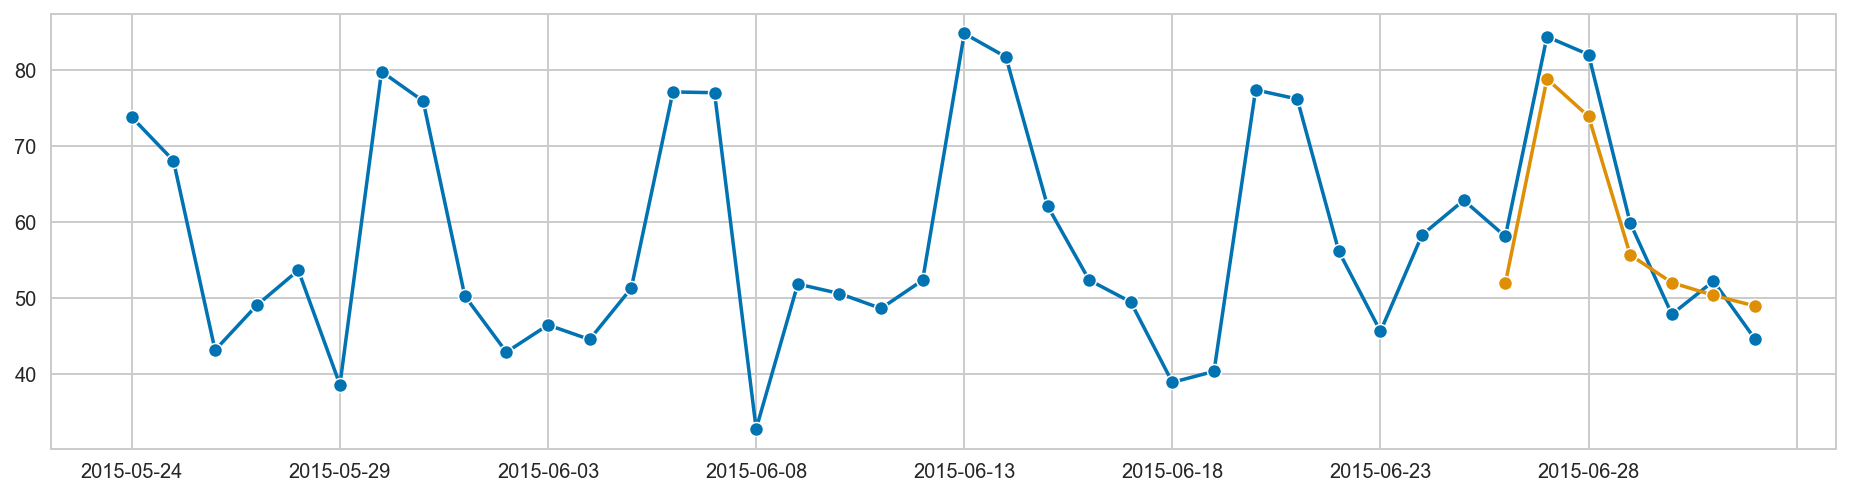

In [33]:
_ = plot_series(dfQty[-40:], yTestPred)

### Pipeline

In [104]:
from sspipe import p, px
import numpy as np
import pandas as pd
import janitor
from scipy import stats

from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV, temporal_train_test_split
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon as FH
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError as MAPE, MeanAbsoluteScaledError as MASE
from sktime.pipeline import make_pipeline
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.naive import NaiveVariance
from lightgbm import LGBMRegressor

import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [102]:
dfQty = (
    pd.read_csv('data/weekly_quantity.csv')
    .eval("date = date.astype('datetime64')", engine='python')
    .set_index('date')
    .rename_axis(index=None)
    .asfreq('D')
    .fillna(1e-3)
    .to_period('D')
)
dfQty.tail()

,quantity
2015-06-28,81.97
2015-06-29,59.83
2015-06-30,47.84
2015-07-01,52.20
2015-07-02,44.57


In [103]:
fhRel = np.arange(1, 8) | p(FH)
yTrain, yTest = temporal_train_test_split(dfQty, fh=fhRel)

In [94]:
pipeline = make_pipeline(
    Deseasonalizer(model='multiplicative', sp=5),
    Detrender(PolynomialTrendForecaster(degree=1)),
    Differencer(lags=1),
    LGBMRegressor() | p(make_reduction, estimator=px, strategy='recursive') | p(NaiveVariance, forecaster=px)
)

paramsDist = {
    'Deseasonalizer__sp': stats.randint(3, 8),
    'NaiveVariance__forecaster__window_length': stats.randint(5, 15),
    'NaiveVariance__forecaster__estimator__n_estimators': stats.randint(10, 50),
    'NaiveVariance__forecaster__estimator__learning_rate': stats.uniform(0.01, 0.5),
    'NaiveVariance__forecaster__estimator__reg_alpha': stats.loguniform(1e-3, 1e3),
    'NaiveVariance__forecaster__estimator__xgboost_dart_mode': [True, False],
}

In [93]:
validator = ForecastingRandomizedSearchCV(
    pipeline,
    strategy='refit',
    cv=ExpandingWindowSplitter(fh=[1,2,3,4,5], initial_window=50, step_length=15),
    param_distributions=paramsDist,
    n_iter=5,
    scoring=MAPE(),
)
validator.fit(yTrain)

ForecastingRandomizedSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5],
                                                         initial_window=50,
                                                         step_length=15),
                              forecaster=TransformedTargetForecaster(steps=[Deseasonalizer(model='multiplicative',
                                                                                           sp=5),
                                                                            Detrender(forecaster=PolynomialTrendForecaster()),
                                                                            Differencer(),
                                                                            NaiveVariance(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor()))]...
                                                   'NaiveVariance__forecaster__estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D43B2D4E80>,
                                                   'NaiveVariance__forecaster__estimator__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D43841E430>,
                                                   'NaiveVariance__forecaster__estimator__xgboost_dart_mode': [True,
                                                                                                               False],
                                                   'NaiveVariance__forecaster__window_length': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D43A599F70>},
                              scoring=MeanAbsolutePercentageError())

In [95]:
validator.cv_results_.sort_values('rank_test_MeanAbsolutePercentageError').head(3)

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
4,0.180602,2.560388,0.020432,"{'Deseasonalizer__sp': 7, 'NaiveVariance__fore...",1.0
3,0.241503,3.556963,0.025442,"{'Deseasonalizer__sp': 4, 'NaiveVariance__fore...",2.0
1,0.265347,2.514780,0.018694,"{'Deseasonalizer__sp': 6, 'NaiveVariance__fore...",3.0


In [97]:
yTestPred = validator.predict(fhRel)
MASE()(yTestPred, yTest, y_train=yTrain)

1.099726316214989

In [98]:
validator.best_params_

{'Deseasonalizer__sp': 7,
 'NaiveVariance__forecaster__estimator__learning_rate': 0.1173060940267036,
 'NaiveVariance__forecaster__estimator__n_estimators': 31,
 'NaiveVariance__forecaster__estimator__reg_alpha': 0.2683490017233269,
 'NaiveVariance__forecaster__estimator__xgboost_dart_mode': False,
 'NaiveVariance__forecaster__window_length': 14}

In [99]:
validator.best_forecaster_

TransformedTargetForecaster(steps=[Deseasonalizer(model='multiplicative', sp=7),
                                   Detrender(forecaster=PolynomialTrendForecaster()),
                                   Differencer(),
                                   NaiveVariance(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.1173060940267036,
                                                                                                                         n_estimators=31,
                                                                                                                         reg_alpha=0.2683490017233269,
                                                                                                                         xgboost_dart_mode=False),
                                                                                                 window_length=14))])

In [101]:
mapeValid = validator.best_score_
mapeTest = MAPE()(yTestPred, yTest)
print(f'MAPEValid={mapeValid:.4f}, MAPETest={mapeTest:.4f}')

MAPEValid=0.1806, MAPETest=0.1838


# References
- *sktime.org - [Forecasting with Sktime](https://nbviewer.org/github/sktime/sktime/blob/4194aacaa105ef59807ea56c1bb3497b37eb1613/examples/01_forecasting.ipynb)*
- *typethepipe.com - [Symmetric MAPE is not symmetric](https://typethepipe.com/post/symmetric-mape-is-not-symmetric/)*
- https://nbviewer.org/github/sktime/sktime/blob/4194aacaa105ef59807ea56c1bb3497b37eb1613/examples/01_forecasting.ipynb
- https://sites.google.com/site/nttrungmtwiki/home/it/data-mining/time-series-analysis/time-series-forecasting-performance-metrics-comparison
- https://www.sktime.org/en/stable/api_reference/performance_metrics.html
- https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
- https://www.relexsolutions.com/resources/measuring-forecast-accuracy/
- https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.mean_absolute_percentage_error.html
- https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.mean_absolute_scaled_error.html#
- https://arxiv.org/pdf/1909.07872.pdf
- https://arxiv.org/pdf/2005.08067.pdf

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*